#### CS166 Pre-class Work for Session 13.1:

### Random Walks

_Yoav Rabinovich, April 2019_

_________________

#### Exercise 2: Diffusion Through a Crack

_Simulate an unbiased random walk (Pr(H) = Pr(T) = 0.5) with some obstacles._

(a) *Put a reflection barrier at x = –4, i.e., the walk may land at –4 but may not stay there, and
the next step must be to –3. Plot a sample path and a histogram.*

(b) *Next, add a partial block at x = 6, i.e., at x = 6 there is only a 0.25 chance of going to 7
and a 0.75 chance of going to 5 (same for 7 to 6 ). Plot a histogram.*

I implemented a more general case, where one can list an arbitrary number of reflectors and filters by stating their positions, and where one can input any bias to the random walk:

In [0]:
import numpy as np
import matplotlib.pyplot as plt

class Diffusion_1D():
    
    def __init__(self,bias=0.5,reflectors=[],filters=[]):
        
        self.state = 0
        self.p = bias
        self.reflectors=reflectors
        self.filters=filters
        
    def step(self):
        
        if self.state in self.reflectors:
            self.state -= 1*np.sign(self.state)
            return
        
        if np.random.uniform(0,1)<self.p:
            if self.state in self.filters:
                if np.random.uniform(0,1)<0.5:
                    self.state += 1
                else:
                    self.state -= 1
            else:
                self.state+=1
        else:
            if self.state-1 in self.filters:
                if np.random.uniform(0,1)<0.5:
                    self.state -= 1
                else:
                    self.state += 1
            else:
                self.state -= 1  
    
    def run(self,steps):
        
        for i in range(steps):
            self.step()
            
        return(self.state)
    
    def analyze(self,runs,steps):
        
        endpoints=[]
        for i in range(runs):
            self.state=0
            endpoints.append(self.run(steps))
            
        return(endpoints)

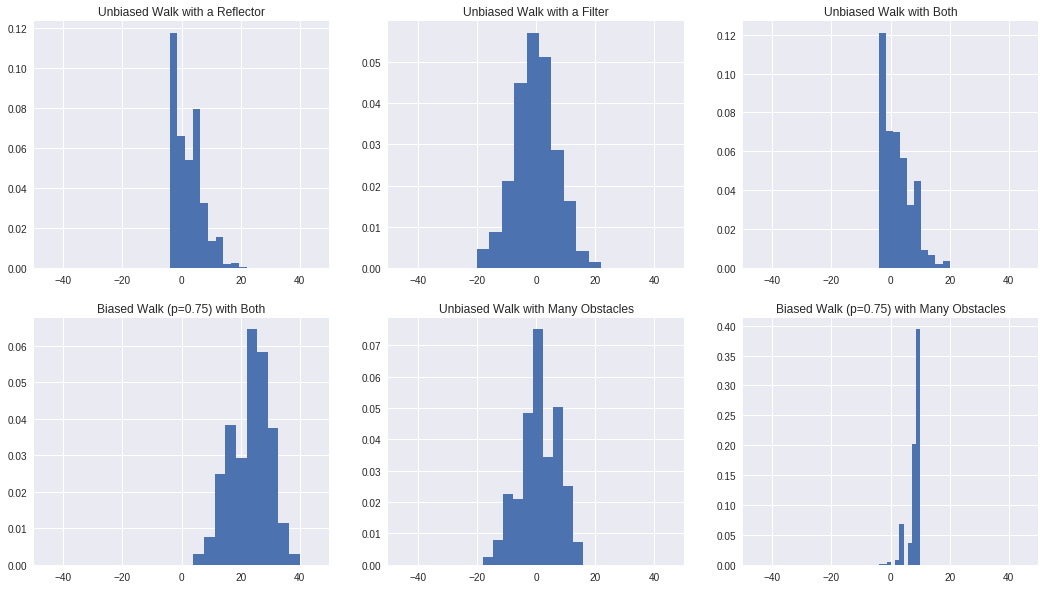

In [0]:
runs = 1000
steps = 50

sim_a = Diffusion_1D(0.5,[-4])
endpoints_a = sim_a.analyze(runs,steps)
sim_b = Diffusion_1D(0.5,filters=[6])
endpoints_b = sim_b.analyze(runs,steps)
sim_c = Diffusion_1D(0.5,[-4],[6])
endpoints_c = sim_c.analyze(runs,steps)
sim_d = Diffusion_1D(0.75,[-4],[6])
endpoints_d = sim_d.analyze(runs,steps)
sim_e = Diffusion_1D(0.5,np.random.randint(-steps,steps,10),np.random.randint(-steps,steps,10))
endpoints_e = sim_e.analyze(runs,steps)
sim_f = Diffusion_1D(0.75,np.random.randint(-steps,steps,10),np.random.randint(-steps,steps,10))
endpoints_f = sim_f.analyze(runs,steps)


plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
plt.title("Unbiased Walk with a Reflector")
plt.xlim(-steps,steps)
plt.hist(endpoints_a,density=True)
plt.subplot(2,3,2)
plt.title("Unbiased Walk with a Filter")
plt.xlim(-steps,steps)
plt.hist(endpoints_b,density=True)
plt.subplot(2,3,3)
plt.title("Unbiased Walk with Both")
plt.xlim(-steps,steps)
plt.hist(endpoints_c,density=True)
plt.subplot(2,3,4)
plt.title("Biased Walk (p=0.75) with Both")
plt.xlim(-steps,steps)
plt.hist(endpoints_d,density=True)
plt.subplot(2,3,5)
plt.title("Unbiased Walk with Many Obstacles")
plt.xlim(-steps,steps)
plt.hist(endpoints_e,density=True)
plt.subplot(2,3,6)
plt.title("Biased Walk (p=0.75) with Many Obstacles")
plt.xlim(-steps,steps)
plt.hist(endpoints_f,density=True)
plt.show()

#### Exercise 4: Wiener Process / Brownian Motion

*Plot the density of end positions for varying step count and step size variance for a Weiner Process walk.*

In [0]:
import numpy as np
import matplotlib.pyplot as plt

class Weiner_2D():
    
    def __init__(self,variance):
        
        self.state = [0,0]
        self.var = variance
        
    def step(self):
        
        degree = np.random.uniform(0,2*np.pi)
        size = np.random.normal(0,self.var)
        dx = size*np.cos(degree)
        dy = size*np.sin(degree)
        
        self.state = [self.state[0]+dx,self.state[1]+dy]
        
    def run(self,steps):
        
        for i in range(steps):
            self.step()
            
        return(self.state)
    
    def analyze(self,runs,steps):
        
        endpoints=[]
        for i in range(runs):
            self.state=[0,0]
            endpoints.append(self.run(steps))
            
        return(endpoints)

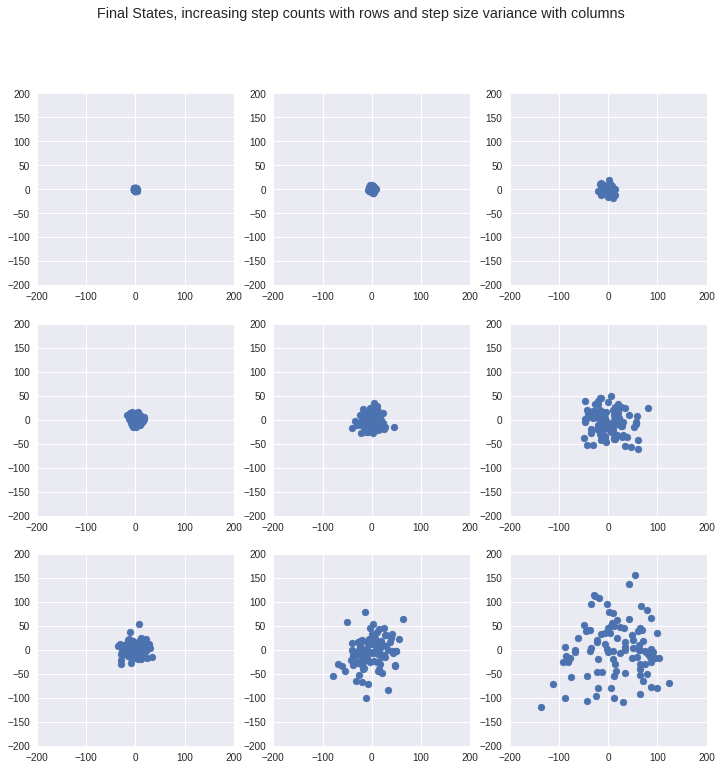

In [0]:
counts = [20,400,1600]
varss = [0.5,1,2]
runs = 100

plt.figure(figsize=(12,12))
plt.suptitle("Final States, increasing step counts with rows and step size variance with columns")
for i in range(len(counts)):
    for j in range(len(varss)):
        sim = Weiner_2D(varss[j])
        endpoints = sim.analyze(runs,counts[i])
        ax = plt.subplot(3,3,1+3*i+j)
        ax.set_xlim([-200,200])
        ax.set_ylim([-200,200])
        ax.scatter([x[0] for x in endpoints],[x[1] for x in endpoints])
        
plt.show()

#### Exercise 9a: : Diffusion in the Plane

_Starting at the origin in the plane, carry out a random walk on the lattice of integer coordinate
points over the square [–20, 20] × [–20, 20]. Assume that there is a square hole whose boundary is
(13, 7), (14, 7), (14, 8), and (13, 8). Walks that reach this hole are absorbed, along with any walk
which reaches the boundary. Show the distribution of final positions for walks of various steps and
especially the fraction that enters the hole._

I implemented instead a class which accepts inputs for the size of the plane and the coordinates of the hole.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

class Doughnut_2D():
    
    def __init__(self,size,hole):
        
        self.bounds = ((-np.int(size[0]/2),np.int(size[0]/2)), \
                      (-np.int(size[1]/2),np.int(size[1]/2)))
        self.holex = range(hole[0][0],hole[1][0]+1)
        self.holey = range(hole[0][1],hole[1][1]+1)
        self.state = [0,0]
        
    def step(self):
        
        # Periodic boundaries
        dimension = np.random.choice([0,1])
        direction = np.random.choice([1,-1])
       
        self.state[dimension] = self.state[dimension]+direction
        
        if self.state[dimension] > self.bounds[dimension][1]:
            self.state[dimension]=self.bounds[dimension][0]
        elif self.state[dimension] < self.bounds[dimension][0]:
            self.state[dimension]=self.bounds[dimension][1]
        
    def run(self,steps):
        
        for i in range(steps):
            if (self.state[0] in self.holex) and (self.state[1] in self.holey):
                break
            self.step()
            
        return(self.state)
    
    def analyze(self,runs,steps):
        
        endpoints=[]
        for i in range(runs):
            self.state=[0,0]
            endpoints.append(self.run(steps))
            
        return(endpoints)

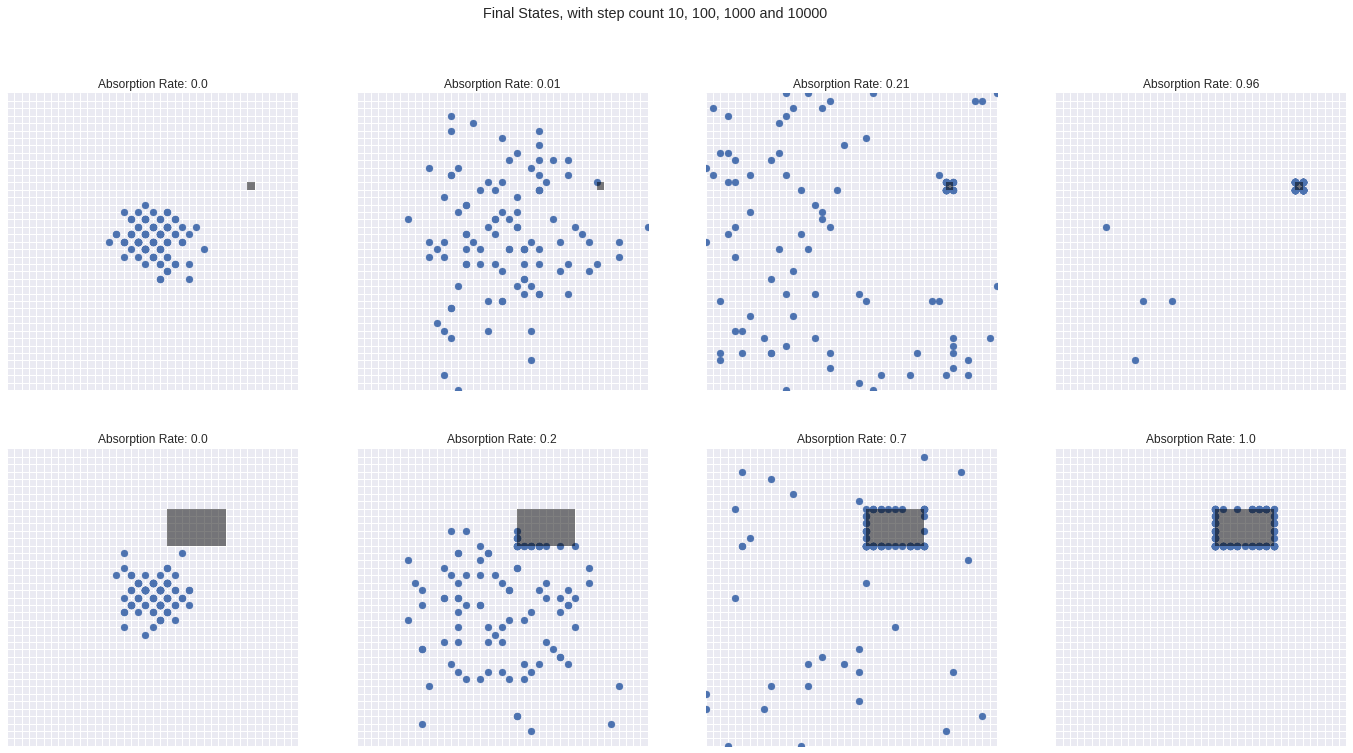

In [0]:
size=(40,40)
holes=[((13,7),(14,8)),((2,7),(10,12))]
counts=[10,100,1000,10000]
runs = 100

plt.figure(figsize=(24,12))
plt.suptitle("Final States, with step count 10, 100, 1000 and 10000")
for h in range(2):
    for i in range(len(counts)):
        sim = Doughnut_2D(size,holes[h])
        endpoints = sim.analyze(runs,counts[i])
        xs = [x[0] for x in endpoints]
        ys = [x[1] for x in endpoints]
        absorbed = 0
        for j in range(len(xs)):
            if xs[j] in sim.holex and ys[j] in sim.holey:
                absorbed += 1
        ax = plt.subplot(2,4,1+4*h+i)
        ax.set_title("Absorption Rate: " +str(absorbed/runs))
        ax.set_xlim(sim.bounds[0])
        ax.set_ylim(sim.bounds[1])
        ax.set_xticks(range(sim.bounds[0][0],sim.bounds[0][1]))
        ax.set_yticks(range(sim.bounds[1][0],sim.bounds[1][1]))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.scatter(xs,ys)
        ax.fill([sim.holex[0],sim.holex[0],sim.holex[-1],sim.holex[-1]] \
                ,[sim.holey[0],sim.holey[-1],sim.holey[-1],sim.holey[0]],"black",alpha=0.5)

plt.show()